# Computing the Euler characteristic and entropy from rs_fMRI data
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Introduction**
In this notebook, we compute the Euler characteristic, entropy and Betti numbers from simplicial complexes representing functional neural networks. The networks are constructed using rs-fMRI (resting-state functional magnetic resonance imaging) data.

## Importing data

**Import libraries**

In [46]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import glob

**Import data**

Generate an average connectivity matrix from the whole human connectome dataset.

In [47]:
# Importing all matrices to generate averaged data with Numpy or Pandas
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

# Averaging matrices with Numpy
MatAv = np.zeros(shape=matrices[0].shape)
for matrix in matrices:
    MatAv += matrix

matrix = MatAv/len(matrices)

# Betti numbers, Euler Characteristic and entropy

**Betti numbers**

A set of topological invariants are the Betti numbers (𝛽). Given that a simplicial complex is a high-dimensional structure, 𝛽𝑘 counts the number of k-dimensional holes in the simplicial complex. These are topological invariants that cor-respond, for each 𝑘≥0, to the number of linearly independent k-dimensional holes in the simplicial complex.

In [48]:
# Import TDA functions
%run TDA.py

In [49]:
# Compute a sparser graph (10%)
G_d10 = densthr(0.1, matrix)

# Compute Betti number
Betti_k(G_d10, 1)

13

In [50]:
Betti_list = []

for i in np.arange(0.1,0.3,0.2):
    G = densthr(i, matrix)
    Betti_number = Betti_k(G, 1)
    Betti_list.append(Betti_number)

print(Betti_list)

[13]


**Euler Characteristic**

Another topological invariant is the Euler characteristic. From this value we can compute the Euler entropy of the network.

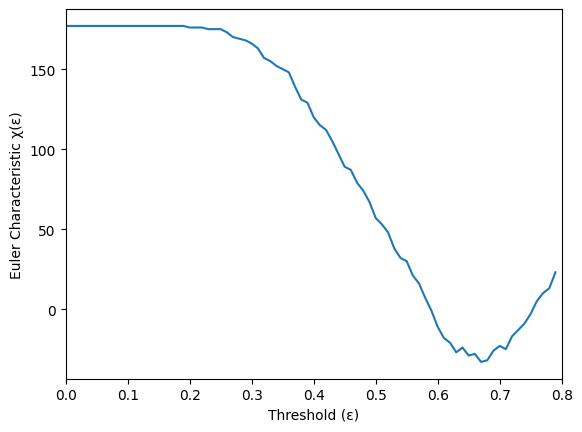

In [51]:
# Plot the Euler characteristic for a given threshold interval
i = matrix
maxvalue = 80
plt.plot(Eulerchoice_thr(i,maxvalue,0))
plt.xlabel('Correlation threshold (ε)')
plt.ylabel('Euler Characteristic χ(ε)')
locs, labels = plt.xticks()
plt.xticks(locs, list(locs/100))
plt.xlim(0, maxvalue)
plt.show()

In [60]:
# Plot the Euler entropy for a given threshold interval
i = matrix
maxvalue = 70
plt.plot(np.log(np.abs(Eulerchoice_thr(i, maxvalue, 0))))
plt.xlabel('Correlation threshold (ε)')
plt.ylabel('Euler Entropy S(ε)')
locs, labels = plt.xticks()
plt.xticks(locs, list(locs/100))
plt.xlim(0, maxvalue)
plt.show()

KeyboardInterrupt: 

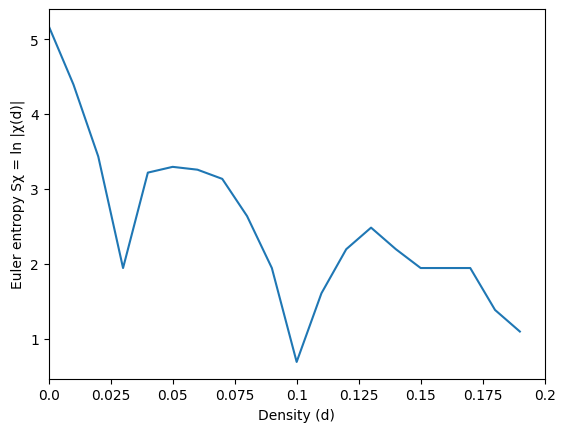

In [20]:
# Euler entropy (Sχ = ln|χ|) as a function of the correlation density level.
plotEuler_den(matrix, 20)

**Repeat entropy for individual brains and their average**

In [77]:
# Extended plot for the Euler entropy for a given threshold interval
data_size = 10 # amount of matrices
maxvalue = 60
entropy_list = []

for matrix in matrices[:data_size]:
    entropy = np.log(np.abs(Eulerchoice_thr(matrix, maxvalue, 0)))
    entropy_list.append(entropy)

average_entropy = [sum(x) / data_size for x in zip(*entropy_list)]

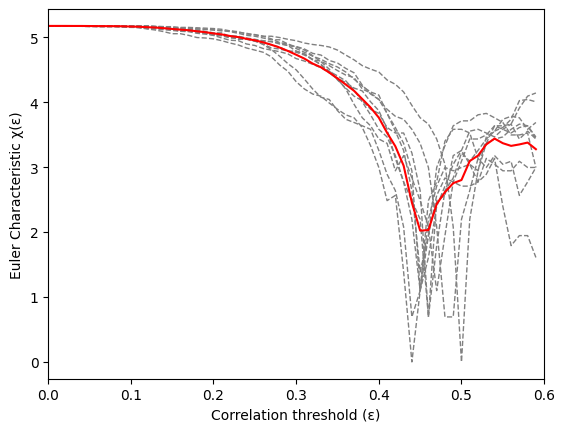

In [78]:
# Plot averaged entropy
for i in range(0, len(entropy_list)):
    plt.plot(entropy_list[i], color='grey', linestyle='--', linewidth=1)
plt.plot(average_entropy, 'r-')
plt.xlabel('Correlation threshold (ε)')
plt.ylabel('Euler Characteristic χ(ε)')
locs, labels = plt.xticks()
plt.xticks(locs, list(locs/100))
plt.xlim(0, maxvalue)
plt.show()